# Learning PySpark
## Chapter 3: DataFrames

This notebook contains sample code from Chapter 3 of [Learning PySpark]() focusing on PySpark and DataFrames.

In [1]:
import pyspark


sc = pyspark.SparkContext("local", "AppCh3")
sqlContext = pyspark.SQLContext(sc)

### Generate your own DataFrame
Instead of accessing the file system, let's create a DataFrame by generating the data.  In this case, we'll first create the `stringRDD` RDD and then convert it into a DataFrame when we're reading `stringJSONRDD` using `spark.read.json`.

In [2]:
# Generate our own JSON data 
#   This way we don't have to access the file system yet.
stringJSONRDD = sc.parallelize((""" 
  { "id": "123",
    "name": "Katie",
    "age": 19,
    "eyeColor": "brown"
  }""",
   """{
    "id": "234",
    "name": "Michael",
    "age": 22,
    "eyeColor": "green"
  }""", 
  """{
    "id": "345",
    "name": "Simone",
    "age": 23,
    "eyeColor": "blue"
  }""")
)

In [3]:
# Create DataFrame
swimmersJSON = sqlContext.read.json(stringJSONRDD)

In [4]:
# Create temporary table
swimmersJSON.createOrReplaceTempView("swimmersJSON")

In [5]:
# DataFrame API
print(type(swimmersJSON))
swimmersJSON.show()

<class 'pyspark.sql.dataframe.DataFrame'>
+---+--------+---+-------+
|age|eyeColor| id|   name|
+---+--------+---+-------+
| 19|   brown|123|  Katie|
| 22|   green|234|Michael|
| 23|    blue|345| Simone|
+---+--------+---+-------+



#### Pandas DataFrames and pyspark dataFrames

The dataframe can be converted to a pandas dataframe easily:

In [6]:
df = swimmersJSON.toPandas()

... and backwards.

In [7]:
swimmersJSON_from_pandas = sqlContext.createDataFrame(df)
swimmersJSON_from_pandas.show()

+---+--------+---+-------+
|age|eyeColor| id|   name|
+---+--------+---+-------+
| 19|   brown|123|  Katie|
| 22|   green|234|Michael|
| 23|    blue|345| Simone|
+---+--------+---+-------+



#### Sql query:

In [8]:
sqlContext.sql("select * from swimmersJSON").collect()

[Row(age=19, eyeColor='brown', id='123', name='Katie'),
 Row(age=22, eyeColor='green', id='234', name='Michael'),
 Row(age=23, eyeColor='blue', id='345', name='Simone')]

#### Inferring the Schema Using Reflection
Note that Apache Spark is inferring the schema using reflection; i.e. it automaticlaly determines the schema of the data based on reviewing the JSON data.

In [9]:
# Print the schema
swimmersJSON.printSchema()

root
 |-- age: long (nullable = true)
 |-- eyeColor: string (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)



Notice that Spark was able to determine infer the schema (when reviewing the schema using `.printSchema`).

But what if we want to programmatically specify the schema?

#### Programmatically Specifying the Schema
In this case, let's specify the schema for a `CSV` text file.

In [10]:
from pyspark.sql import types

# Generate our own CSV data 
#   This way we don't have to access the file system yet.
stringCSVRDD = sc.parallelize(
    [
        (123, 'Katie', 19, 'brown'), 
        (234, 'Michael', 22, 'green'), 
        (345, 'Simone', 23, 'blue')
    ]
)

# The schema is encoded in a string, using StructType we define the schema using various pyspark.sql.types
schemaString = "id name age eyeColor"
schema = types.StructType(
    [
        types.StructField("id",       types.LongType(),   True),    
        types.StructField("name",     types.StringType(), True),
        types.StructField("age",      types.LongType(),   True),
        types.StructField("eyeColor", types.StringType(), True)
    ]
)

# Apply the schema to the RDD and Create DataFrame
swimmers = sqlContext.createDataFrame(stringCSVRDD, schema)

# Creates a temporary view using the DataFrame
swimmers.createOrReplaceTempView("swimmers")

In [11]:
# Print the schema
#   Notice that we have redefined id as Long (instead of String)
print(type(swimmers))
swimmers.printSchema()

<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- age: long (nullable = true)
 |-- eyeColor: string (nullable = true)



As you can see from above, we can programmatically apply the `schema` instead of allowing the Spark engine to infer the schema via reflection.

Additional Resources include:
* [PySpark API Reference](https://spark.apache.org/docs/2.0.0/api/python/pyspark.sql.html)
* [Spark SQL, DataFrames, and Datasets Guide](https://spark.apache.org/docs/latest/sql-programming-guide.html#programmatically-specifying-the-schema): This is in reference to Programmatically Specifying the Schema using a `CSV` file.

## Intedlude: the spark UI

Browsing the spark UI should give an idea how can `sqlContext.sql("select * from swimmersJSON").collect()` work from the jupyter notebook, even if swimmerJSON is passed as a string and not as a variable.

In [12]:
spark_host = "localhost"
local_port = sc.uiWebUrl.split(':')[-1]

spark_UI_url = f"http://{spark_host}:{local_port}/jobs/"

print(spark_UI_url)

http://localhost:4041/jobs/


In [13]:
import webbrowser

webbrowser.open(spark_UI_url)

True

## SparkSession: queries via sql and API

* Entry point for reading data
* Working with metadata
* Configuration
* Cluster resource management

For more information, please refer to [How to use SparkSession in Apache Spark 2.0](http://bit.ly/2br0Fr1) (http://bit.ly/2br0Fr1).

Get the table names and the elements in swimmers

In [14]:
print(sqlContext.tableNames())
swimmers.count()

['swimmers', 'swimmersjson']


3

With DataFrames, you can start writing your queries using `Spark SQL` - a SQL dialect that is compatible with the Hive Query Language (or HiveQL).

Execute an sql query and return the data:

In [15]:
sqlContext.sql("select * from swimmers").show()

+---+-------+---+--------+
| id|   name|age|eyeColor|
+---+-------+---+--------+
|123|  Katie| 19|   brown|
|234|Michael| 22|   green|
|345| Simone| 23|    blue|
+---+-------+---+--------+



... and convert to a Pandas dataframe

In [16]:
sqlContext.sql("select * from swimmers").toPandas()

,id,name,age,eyeColor
0,123,Katie,19,brown
1,234,Michael,22,green
2,345,Simone,23,blue


Let's get the row count:

In [17]:
sqlContext.sql("select count(1) from swimmers").show()

+--------+
|count(1)|
+--------+
|       3|
+--------+



Query id and age for swimmers with age = 22 via sql and API

In [18]:
sqlContext.sql("select id, age from swimmers where age = 22").show()

+---+---+
| id|age|
+---+---+
|234| 22|
+---+---+



In [19]:
swimmers.select("id", "age").filter("age = 22").show()

+---+---+
| id|age|
+---+---+
|234| 22|
+---+---+



In [20]:
swimmers.select(swimmers.id, swimmers.age).filter(swimmers.age == 22).show()

+---+---+
| id|age|
+---+---+
|234| 22|
+---+---+



**Exercise:** transform the following sql query in an API query

In [21]:
sqlContext.sql("select name, eyeColor from swimmers where eyeColor like 'b%'").show()

+------+--------+
|  name|eyeColor|
+------+--------+
| Katie|   brown|
|Simone|    blue|
+------+--------+



# On-Time Flight Performance Showcase

We analyse the *Airline On-time Performance and Causes of Flights dealy*, based on the followdig datasets:

+ https://catalog.data.gov/dataset/airline-on-time-performance-and-causes-of-flight-delays-on-time-data  (from the book - link out of date)

+ https://openflights.org/data.html

And copyied locally under `./Data`.

### DataFrame Queries
Let's run a flight performance using DataFrames; let's first build the DataFrames from the source datasets.

In [22]:
data_folder = os.path.join(os.path.dirname(os.getcwd()), "Data")

# Set File Paths
flightPerfFilePath = os.path.join(data_folder, "departuredelays.csv")
airportsFilePath = os.path.join(data_folder, "airport-codes-na.txt")

for f in [flightPerfFilePath, airportsFilePath]:
    assert os.path.exists(f), f"File {f} not found."

# Obtain Airports dataset
airports = sqlContext.read.csv(airportsFilePath, header='true', inferSchema='true', sep='\t')
airports.createOrReplaceTempView("airports")

# Obtain Departure Delays dataset
flightPerf = sqlContext.read.csv(flightPerfFilePath, header='true')
flightPerf.createOrReplaceTempView("FlightPerformance")

# Cache the Departure Delays dataset 
flightPerf.cache()

DataFrame[date: string, delay: string, distance: string, origin: string, destination: string]

List the tables in the current context and list the number of elements:

In [23]:
print(sqlContext.tableNames())
print(airports.count())
flightPerf.count()

['airports', 'flightperformance', 'swimmers', 'swimmersjson']
526


1391578

Query Sum of Flight Delays by City and Origin Code (for Washington State).

Equivalent sql code is:

```sql
select a.City, f.origin, sum(f.delay) as Delays
  from FlightPerformance f
    join airports a
      on a.IATA = f.origin
 where a.State = 'WA'
 group by a.City, f.origin
 order by sum(f.delay) desc
```


In [24]:
sqlContext.sql("select a.City, f.origin, sum(f.delay) as Delays from FlightPerformance f join airports a on a.IATA = f.origin where a.State = 'WA' group by a.City, f.origin order by sum(f.delay) desc").show()

+-------+------+--------+
|   City|origin|  Delays|
+-------+------+--------+
|Seattle|   SEA|159086.0|
|Spokane|   GEG| 12404.0|
|  Pasco|   PSC|   949.0|
+-------+------+--------+



Query Sum of Flight Delays by State (for the US)

```sql
select a.State, sum(f.delay) as Delays
  from FlightPerformance f
    join airports a
      on a.IATA = f.origin
 where a.Country = 'USA'
 group by a.State 
```

In [25]:
delays_per_state = sqlContext.sql("select a.State, sum(f.delay) as Delays from FlightPerformance f join airports a on a.IATA = f.origin where a.Country = 'USA' group by a.State ")
delays_per_state.show()

+-----+---------+
|State|   Delays|
+-----+---------+
|   SC|  80666.0|
|   AZ| 401793.0|
|   LA| 199136.0|
|   MN| 256811.0|
|   NJ| 452791.0|
|   OR| 109333.0|
|   VA|  98016.0|
| null| 397237.0|
|   RI|  30760.0|
|   WY|  15365.0|
|   KY|  61156.0|
|   NH|  20474.0|
|   MI| 366486.0|
|   NV| 474208.0|
|   WI| 152311.0|
|   ID|  22932.0|
|   CA|1891919.0|
|   CT|  54662.0|
|   NE|  59376.0|
|   MT|  19271.0|
+-----+---------+
only showing top 20 rows



**Exercise:** rewrite the queries above from sql to API.

## Data visualisation:

You can visualize the data using databricks (the query above in the databrics environment), or you can use some python libraries.

In [26]:
df_delays = delays_per_state.toPandas()
df_delays.head(10)

,State,Delays
0,SC,80666.0
1,AZ,401793.0
2,LA,199136.0
3,MN,256811.0
4,NJ,452791.0
5,OR,109333.0
6,VA,98016.0
7,None,397237.0
8,RI,30760.0
9,WY,15365.0


In [27]:
df_delays.fillna("DE", inplace=True)  # add Delaware, missing state.

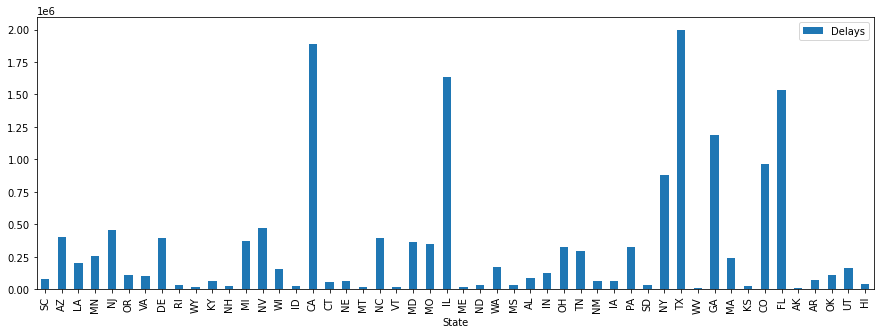

In [28]:
import matplotlib.pyplot as plt

df_delays_index_state = df_delays.set_index('State')
df_delays_index_state.plot.bar(figsize=(15,5))

In [29]:
import folium
import pandas as pd


url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'
# state_unemployment = f'{url}/US_Unemployment_Oct2012.csv'
# state_data = pd.read_csv(state_unemployment)

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=df_delays,
    columns=['State', 'Delays'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Unemployment Rate (%)'
).add_to(m)

folium.LayerControl().add_to(m)

m

In [30]:
flightPerf.columns

['date', 'delay', 'distance', 'origin', 'destination']

** Exercise:** from the dataset alone it is not possible to get the number of total fligths in the queried states, therefore we can not normalise and show the delay rate (e.g. states with more flight will have more delays, does not mean that delays are overall more frequent).
Finding the dataset and normalising the data is left as an exercise

For more information, please refer to:
* [Spark SQL, DataFrames and Datasets Guide](http://spark.apache.org/docs/latest/sql-programming-guide.html#sql)
* [PySpark SQL Module: DataFrame](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame)
* [PySpark SQL Functions Module](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions)

## Chapter's Summary:

+ Craeting Dataframes
    + Generating a JSON table
    + `sqlContext`
    + Creating a temporary view
    + Interlude: open the Spark UI
+ Simple DataFrame queries
    + Via sql or API
        + .show
        + .sql
        + .select
        + .filte
+ Case study: delayed flights